# Pairing PA and EPA sensors within certain distances

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.ops import nearest_points
from tqdm import tqdm
import numpy as np
import itertools, statsmodels.formula.api as smf
from sklearn.cluster import DBSCAN
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from shapely.geometry import Point

In [3]:
EPA_SHP   = "../Data/Output/epa_pm25_history.shp"      
PA_SHP    = "../Data/Output/Purpleair_pm25_valid.shp"    
PAIR_CSV  = "../Data/Output/epa_pa_daily_pairs.csv"

epa = gpd.read_file(EPA_SHP)
pa  = gpd.read_file(PA_SHP)

# NAD83 / California Zone V (US Survey Foot) radius_ft = miles * 5280 => epa_geom.buffer(radius_ft)
epa_wgs = epa.to_crs("EPSG:4326")
epa["EPA_LON"] = epa_wgs.geometry.x
epa["EPA_LAT"] = epa_wgs.geometry.y
nad83ca5 = "EPSG:2229"
epa = epa.to_crs(nad83ca5)
pa  = pa.to_crs(nad83ca5)

pa["date"] = pd.to_datetime(pa["date"]) 
pa = pa.replace(np.nan, 0)
pa["humidity"] = (pa["humidity_a"] + pa["humidity_b"])/2
pa["pressure"] = (pa["pressure_a"] + pa["pressure_b"])/2
pa["tempature"] = (pa["temperatur"] + pa["temperat_1"])/2
pa_grp = {d: sub for d, sub in pa.groupby(pa["date"].dt.date)} # group by date

In [4]:
epa.columns
epa['Site ID'].value_counts() #17

Site ID
60371103    1804
60590007    1554
60371302    1434
60374008    1270
60374004    1011
60371201     968
60374010     724
60376012     723
60379033     721
60370016     705
60592022     590
60371602     307
60374009     260
60372005     238
60370002     206
60374002     184
60379034     109
Name: count, dtype: int64

In [5]:
pa.columns

Index(['Unnamed_ 0', 'sensor_id', 'date', 'time_stamp', 'rssi', 'uptime_x',
       'pa_latency', 'humidity_a', 'humidity_b', 'temperatur', 'temperat_1',
       'pressure_a', 'pressure_b', 'voc_a', 'voc_b', 'pm2.5_atm_',
       'pm2.5_at_1', 'pm10.0_atm', 'pm10.0_a_1', 'sensor_ind', 'date_creat',
       'location_t', 'model', 'uptime_y', 'position_r', 'latitude',
       'longitude', 'altitude', 'confidence', 'pm25_avg', 'geometry',
       'humidity', 'pressure', 'tempature'],
      dtype='object')

In [6]:
records = []

for idx, row in tqdm(epa.iterrows(), total = len(epa), desc = "EPA sensors"):
    epa_geom  = row.geometry
    epa_date  = pd.to_datetime(row["Date"]).date()
    
    if epa_date not in pa_grp:
        continue
    pa_today = pa_grp[epa_date]
    
    for miles in (0.25, 0.5, 0.75, 1.0, 1.25, 1.5):
        radius_ft = miles * 5280 # mile -> feet
        sel = pa_today[pa_today.geometry.within(epa_geom.buffer(radius_ft))]  
        if sel.empty:
            continue
        epa_pm = row["Daily Mean"] # sensor list (fall in the buffer)
        for _, pa_row in sel.iterrows():
            records.append({
                "EPA_SiteID" : row["Site ID"],
                "Date" : epa_date.strftime("%Y-%m-%d"),
                "Distance_mi" : miles,
                "EPA_PM25" : epa_pm,
                "EPA_LON" : row["EPA_LON"],
                "EPA_LAT" : row["EPA_LAT"],
                "PurpleAir_ID" : pa_row["sensor_id"],
                "PurpleAir_PM25" : pa_row["pm25_avg"],
                "PurpleAir_RH": pa_row["humidity"],
                "PurpleAir_T": pa_row["tempature"],
                "PurpleAir_P": pa_row["pressure"],
                "PA_AGE": pa_row["date_creat"],
                "PA_model": pa_row["model"],
                "PA_LON": pa_row['longitude'],
                "PA_LAT": pa_row['latitude']
            })

EPA sensors: 100%|██████████| 12808/12808 [01:15<00:00, 168.54it/s]


In [13]:
pair_raw = pd.DataFrame(records)

epa_pts = gpd.GeoSeries(
    Point(xy) for xy in zip(pair_raw["EPA_LON"], pair_raw["EPA_LAT"])
).set_crs("EPSG:4326") # WGS84
pa_pts = gpd.GeoSeries(Point(xy) for xy in zip(pair_raw["PA_LON"], pair_raw["PA_LAT"])).set_crs("EPSG:4326")

pair_raw = pair_raw.join(gpd.GeoDataFrame({"epa_geom": epa_pts, "pa_geom": pa_pts}))

pair_raw = pair_raw.set_geometry("epa_geom").to_crs(3857)
pair_raw["epa_geom"] = pair_raw.geometry
pair_raw = pair_raw.set_geometry("pa_geom").to_crs(3857)
pair_raw["true_dist_m"] = pair_raw.distance(pair_raw["epa_geom"])
pair_raw["true_dist_mi"] = pair_raw["true_dist_m"] / 1609.34

In [121]:
# if PurpleAir connected to multiple EPA monitors, keep the closest one ------- 0.25 mi buffer
pair_raw_025 = pair_raw[pair_raw["Distance_mi"] == 0.25]
dup_mask = pair_raw_025.duplicated(subset = ["PurpleAir_ID", "Date"], keep = False)
dup = pair_raw_025[dup_mask]

keep_idx = (
    dup.sort_values("true_dist_mi")
       .groupby(["PurpleAir_ID", "Date"])
       .head(1)
       .index
)

pair_final_025 = pd.concat([
    pair_raw_025[~dup_mask],
    pair_raw_025.loc[keep_idx]
]).reset_index(drop=True)

print(f"{len(pair_final_025)}/{len(pair_raw_025)} left")
pair_final_025.to_csv('../Data/Output/Paired_table_025.csv', index = False)

3650/5383 left


In [19]:
# if PurpleAir connected to multiple EPA monitors, keep the closest one ------- 0.5 mi buffer
pair_raw_05 = pair_raw[pair_raw["Distance_mi"] == 0.5]
dup_mask = pair_raw_05.duplicated(subset = ["PurpleAir_ID", "Date"], keep = False)
dup = pair_raw_05[dup_mask]

keep_idx = (
    dup.sort_values("true_dist_mi")
       .groupby(["PurpleAir_ID", "Date"])
       .head(1)
       .index
)

pair_final_05 = pd.concat([
    pair_raw_05[~dup_mask],
    pair_raw_05.loc[keep_idx]
]).reset_index(drop=True)

print(f"{len(pair_final_05)}/{len(pair_raw_05)} left")
pair_final_05.to_csv('../Data/Output/Paired_table_05.csv', index = False)

4627/6467 left


In [23]:
# if PurpleAir connected to multiple EPA monitors, keep the closest one ------- 0.75 mi buffer
pair_raw_075 = pair_raw[pair_raw["Distance_mi"] == 0.75]
dup_mask = pair_raw_075.duplicated(subset = ["PurpleAir_ID", "Date"], keep = False)
dup = pair_raw_075[dup_mask]

keep_idx = (
    dup.sort_values("true_dist_mi")
       .groupby(["PurpleAir_ID", "Date"])
       .head(1)
       .index
)

pair_final_075 = pd.concat([
    pair_raw_075[~dup_mask],
    pair_raw_075.loc[keep_idx]
]).reset_index(drop=True)

print(f"{len(pair_final_075)}/{len(pair_raw_075)} left")
pair_final_075.to_csv('../Data/Output/Paired_table_075.csv', index = False)

7493/10448 left


In [25]:
# if PurpleAir connected to multiple EPA monitors, keep the closest one ------- 1 mi buffer
pair_raw_1 = pair_raw[pair_raw["Distance_mi"] == 1]
dup_mask = pair_raw_1.duplicated(subset = ["PurpleAir_ID", "Date"], keep = False)
dup = pair_raw_1[dup_mask]

keep_idx = (
    dup.sort_values("true_dist_mi")
       .groupby(["PurpleAir_ID", "Date"])
       .head(1)
       .index
)

pair_final_1 = pd.concat([
    pair_raw_1[~dup_mask],
    pair_raw_1.loc[keep_idx]
]).reset_index(drop=True)

print(f"{len(pair_final_1)}/{len(pair_raw_1)} left")
pair_final_1.to_csv('../Data/Output/Paired_table_1.csv', index = False)

10353/15209 left


In [27]:
# if PurpleAir connected to multiple EPA monitors, keep the closest one ------- 1.25 mi buffer
pair_raw_125 = pair_raw[pair_raw["Distance_mi"] == 1.25]
dup_mask = pair_raw_125.duplicated(subset = ["PurpleAir_ID", "Date"], keep = False)
dup = pair_raw_125[dup_mask]

keep_idx = (
    dup.sort_values("true_dist_mi")
       .groupby(["PurpleAir_ID", "Date"])
       .head(1)
       .index
)

pair_final_125 = pd.concat([
    pair_raw_125[~dup_mask],
    pair_raw_125.loc[keep_idx]
]).reset_index(drop=True)

print(f"{len(pair_final_125)}/{len(pair_raw_125)} left")
pair_final_125.to_csv('../Data/Output/Paired_table_125.csv', index = False)

13551/19812 left


# Calibration - 0.5 miles

1. Pairing - 把共处同一微区的 EPA 与 PurpleAir 归为一簇，可降低空间异质性 => alternative way: use land use data to do the clustering
2. EPA = beta_cluster + beta_1*PA + beta_2 * RH + beta_3 * T + beta_4 * P + beta_5 * PA_AGE + beta_6 * PA_model + ui (random intercept) + e

In [29]:
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [36]:
pair_df = pd.read_csv('../Data/Output/Paired_table_05.csv')
pair_df["PA_AGE"] = (pd.to_datetime(pair_df["Date"]) -
                pd.to_datetime(pair_df["PA_AGE"])).dt.days / 365.25
pair_df["PA_model"] = pair_df["PA_model"].astype(str)
pair_df["PurpleAir_ID"] = pair_df["PurpleAir_ID"].astype(str)
pair_df.columns

Index(['EPA_SiteID', 'Date', 'Distance_mi', 'EPA_PM25', 'EPA_LON', 'EPA_LAT',
       'PurpleAir_ID', 'PurpleAir_PM25', 'PurpleAir_RH', 'PurpleAir_T',
       'PurpleAir_P', 'PA_AGE', 'PA_model', 'PA_LON', 'PA_LAT', 'epa_geom',
       'pa_geom', 'true_dist_m', 'true_dist_mi'],
      dtype='object')

## clean outliers

In [61]:
pm_lo, pm_hi = 1.5, 1000     # 论文阈值
df = pair_df.copy()
mask_pm = df["PurpleAir_PM25"].between(pm_lo, pm_hi)
df_clean = df.loc[mask_pm].copy()
print(f"records: {len(df_clean):,}（{mask_pm.mean()*100:.1f}%）")

records: 4,379（94.6%）


## EPA calibration equation

In [63]:
y_pred_EPA = (
      0.52  * df_clean["PurpleAir_PM25"]
    - 0.085 * df_clean["PurpleAir_RH"]
    + 5.71
)
y_true =  df_clean.EPA_PM25
print("Daily  R² =", r2_score(y_true, y_pred_EPA).round(3))
print("Daily RMSE =", mean_squared_error(y_true, y_pred_EPA, squared = False).round(2))
print("Daily  MAE =", mean_absolute_error(y_true, y_pred_EPA).round(2))

Daily  R² = 0.558
Daily RMSE = 3.94
Daily  MAE = 2.7


## test OLS

In [75]:
m = smf.ols("EPA_PM25 ~ PurpleAir_PM25 + PurpleAir_RH + PurpleAir_T", data = df_clean).fit()
y_true, y_pred = df_clean.EPA_PM25, m.fittedvalues

print("Daily  R² =", r2_score(y_true, y_pred).round(3))
print("Daily RMSE =", mean_squared_error(y_true, y_pred, squared=False).round(2))
print("Daily  MAE =", mean_absolute_error(y_true, y_pred).round(2))

Daily  R² = 0.594
Daily RMSE = 3.78
Daily  MAE = 2.58


## CrossValidation

In [77]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

In [79]:
y = df_clean["EPA_PM25"].values
X = df_clean[["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]].values
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

scoring = {
    "r2"  : make_scorer(r2_score),
    "rmse": make_scorer(rmse, greater_is_better=False),
    "mae" : make_scorer(mean_absolute_error, greater_is_better=False)
}

In [91]:
# cross validate
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

lin_cv = cross_validate(
    Pipeline([
        ("scale", StandardScaler()),
        ("lin",   LinearRegression())
    ]),
    X, y,
    cv = kf,
    scoring = scoring,
    return_train_score = False
)

pd.DataFrame({
    "Fold": range(1, 11),
    "R2"  :  lin_cv["test_r2"],
    "RMSE": -lin_cv["test_rmse"],
    "MAE" : -lin_cv["test_mae"]
}).assign(
    R2_mean  = np.mean(lin_cv["test_r2"]).round(3),
    RMSE_mean= -np.mean(lin_cv["test_rmse"]).round(2),
    MAE_mean = -np.mean(lin_cv["test_mae"]).round(2)
)

,Fold,R2,RMSE,MAE,R2_mean,RMSE_mean,MAE_mean
0,1,0.620706,3.318398,2.475510,0.592,3.77,2.58
1,2,0.559370,3.384805,2.457406,0.592,3.77,2.58
2,3,0.558578,4.224675,2.833304,0.592,3.77,2.58
3,4,0.574883,3.836417,2.490683,0.592,3.77,2.58
4,5,0.567133,3.800850,2.545318,0.592,3.77,2.58
5,6,0.583413,3.997080,2.597488,0.592,3.77,2.58
6,7,0.571826,4.053777,2.785074,0.592,3.77,2.58
7,8,0.603397,3.624650,2.535846,0.592,3.77,2.58
8,9,0.651236,3.690307,2.535516,0.592,3.77,2.58
9,10,0.632396,3.780316,2.583612,0.592,3.77,2.58


# Calibration - 0.25 mi

In [287]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
pair_df = pd.read_csv('../Data/Output/Paired_table_025.csv')
pair_df["PA_AGE"] = (pd.to_datetime(pair_df["Date"]) -
                     pd.to_datetime(pair_df["PA_AGE"])).dt.days / 365.25
pair_df["PA_model"] = pair_df["PA_model"].astype(str)
pair_df["PurpleAir_ID"] = pair_df["PurpleAir_ID"].astype(str)

pm_lo, pm_hi = 1.5, 1000
df_clean = pair_df.loc[
    pair_df["PurpleAir_PM25"].between(pm_lo, pm_hi)
].copy()
y = df_clean["EPA_PM25"].values

# metrics
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

scoring = {
    "r2":   make_scorer(r2_score),
    "rmse": make_scorer(rmse, greater_is_better=False),
    "mae":  make_scorer(mean_absolute_error, greater_is_better=False)
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

feature_sets = {
    "PA":              ["PurpleAir_PM25"],
    "PA+RH":           ["PurpleAir_PM25", "PurpleAir_RH"],
    "PA+T":            ["PurpleAir_PM25", "PurpleAir_T"],
    "PA+RH+T":         ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "Poly2(PA+RH+T)":  ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "logPA+RH+T":      ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]
}

results = []

for name, feats in feature_sets.items():
    X = df_clean[feats]

    if name == "Poly2(PA+RH+T)":                       # 二次项
        num_pipe = Pipeline([
            ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
            ("scale",  StandardScaler())
        ])
    elif name.startswith("logPA"):                     # log 变换
        transformer = ColumnTransformer(
            transformers=[
                ("log_pa", FunctionTransformer(np.log1p), ["PurpleAir_PM25"]),
                ("others", "passthrough", ["PurpleAir_RH", "PurpleAir_T"])
            ],
            remainder="drop"
        )
        num_pipe = Pipeline([
            ("trans",  transformer),
            ("scale",  StandardScaler())
        ])
    else: 
        num_pipe = Pipeline([
            ("scale",  StandardScaler())
        ])

    pipe = Pipeline([
        ("prep", num_pipe),
        ("lin",  LinearRegression())
    ])

    cv = cross_validate(pipe, X, y, cv=kf, scoring=scoring,
                        return_train_score=False)

    results.append({
        "Model": name,
        "R2":   cv["test_r2"].mean().round(3),
        "RMSE": (-cv["test_rmse"]).mean().round(2),
        "MAE":  (-cv["test_mae"]).mean().round(2)
    })

cv_summary = pd.DataFrame(results).sort_values("R2", ascending=False)
print(cv_summary)

            Model     R2  RMSE   MAE
4  Poly2(PA+RH+T)  0.680  3.31  2.42
3         PA+RH+T  0.663  3.41  2.48
1           PA+RH  0.651  3.47  2.54
2            PA+T  0.645  3.50  2.56
0              PA  0.641  3.53  2.60
5      logPA+RH+T  0.535  4.04  2.85


# Calibration - 0.5 mi

In [140]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
pair_df = pd.read_csv('../Data/Output/Paired_table_05.csv')
pair_df["PA_AGE"] = (pd.to_datetime(pair_df["Date"]) -
                     pd.to_datetime(pair_df["PA_AGE"])).dt.days / 365.25
pair_df["PA_model"] = pair_df["PA_model"].astype(str)
pair_df["PurpleAir_ID"] = pair_df["PurpleAir_ID"].astype(str)

pm_lo, pm_hi = 1.5, 1000
df_clean = pair_df.loc[
    pair_df["PurpleAir_PM25"].between(pm_lo, pm_hi)
].copy()
y = df_clean["EPA_PM25"].values

# metrics
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

scoring = {
    "r2":   make_scorer(r2_score),
    "rmse": make_scorer(rmse, greater_is_better=False),
    "mae":  make_scorer(mean_absolute_error, greater_is_better=False)
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

feature_sets = {
    "PA":              ["PurpleAir_PM25"],
    "PA+RH":           ["PurpleAir_PM25", "PurpleAir_RH"],
    "PA+T":            ["PurpleAir_PM25", "PurpleAir_T"],
    "PA+RH+T":         ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "Poly2(PA+RH+T)":  ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "logPA+RH+T":      ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]
}

results = []

for name, feats in feature_sets.items():
    X = df_clean[feats]

    if name == "Poly2(PA+RH+T)":                       # 二次项
        num_pipe = Pipeline([
            ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
            ("scale",  StandardScaler())
        ])
    elif name.startswith("logPA"):                     # log 变换
        transformer = ColumnTransformer(
            transformers=[
                ("log_pa", FunctionTransformer(np.log1p), ["PurpleAir_PM25"]),
                ("others", "passthrough", ["PurpleAir_RH", "PurpleAir_T"])
            ],
            remainder="drop"
        )
        num_pipe = Pipeline([
            ("trans",  transformer),
            ("scale",  StandardScaler())
        ])
    else: 
        num_pipe = Pipeline([
            ("scale",  StandardScaler())
        ])

    pipe = Pipeline([
        ("prep", num_pipe),
        ("lin",  LinearRegression())
    ])

    cv = cross_validate(pipe, X, y, cv=kf, scoring=scoring,
                        return_train_score=False)

    results.append({
        "Model": name,
        "R2":   cv["test_r2"].mean().round(3),
        "RMSE": (-cv["test_rmse"]).mean().round(2),
        "MAE":  (-cv["test_mae"]).mean().round(2)
    })

cv_summary = pd.DataFrame(results).sort_values("R2", ascending=False)
print(cv_summary)

            Model     R2  RMSE   MAE
4  Poly2(PA+RH+T)  0.612  3.67  2.54
3         PA+RH+T  0.592  3.77  2.58
1           PA+RH  0.576  3.85  2.65
2            PA+T  0.573  3.86  2.66
0              PA  0.568  3.88  2.68
5      logPA+RH+T  0.460  4.35  2.91


# Calibration - 0.75 mi

In [144]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
pair_df = pd.read_csv('../Data/Output/Paired_table_075.csv')
pair_df["PA_AGE"] = (pd.to_datetime(pair_df["Date"]) -
                     pd.to_datetime(pair_df["PA_AGE"])).dt.days / 365.25
pair_df["PA_model"] = pair_df["PA_model"].astype(str)
pair_df["PurpleAir_ID"] = pair_df["PurpleAir_ID"].astype(str)

pm_lo, pm_hi = 1.5, 1000
df_clean = pair_df.loc[
    pair_df["PurpleAir_PM25"].between(pm_lo, pm_hi)
].copy()
y = df_clean["EPA_PM25"].values

# metrics
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

scoring = {
    "r2":   make_scorer(r2_score),
    "rmse": make_scorer(rmse, greater_is_better=False),
    "mae":  make_scorer(mean_absolute_error, greater_is_better=False)
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

feature_sets = {
    "PA":              ["PurpleAir_PM25"],
    "PA+RH":           ["PurpleAir_PM25", "PurpleAir_RH"],
    "PA+T":            ["PurpleAir_PM25", "PurpleAir_T"],
    "PA+RH+T":         ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "Poly2(PA+RH+T)":  ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "logPA+RH+T":      ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]
}

results = []

for name, feats in feature_sets.items():
    X = df_clean[feats]

    if name == "Poly2(PA+RH+T)":                       # 二次项
        num_pipe = Pipeline([
            ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
            ("scale",  StandardScaler())
        ])
    elif name.startswith("logPA"):                     # log 变换
        transformer = ColumnTransformer(
            transformers=[
                ("log_pa", FunctionTransformer(np.log1p), ["PurpleAir_PM25"]),
                ("others", "passthrough", ["PurpleAir_RH", "PurpleAir_T"])
            ],
            remainder="drop"
        )
        num_pipe = Pipeline([
            ("trans",  transformer),
            ("scale",  StandardScaler())
        ])
    else: 
        num_pipe = Pipeline([
            ("scale",  StandardScaler())
        ])

    pipe = Pipeline([
        ("prep", num_pipe),
        ("lin",  LinearRegression())
    ])

    cv = cross_validate(pipe, X, y, cv=kf, scoring=scoring,
                        return_train_score=False)

    results.append({
        "Model": name,
        "R2":   cv["test_r2"].mean().round(3),
        "RMSE": (-cv["test_rmse"]).mean().round(2),
        "MAE":  (-cv["test_mae"]).mean().round(2)
    })

cv_summary = pd.DataFrame(results).sort_values("R2", ascending=False)
print(cv_summary)

            Model     R2  RMSE   MAE
4  Poly2(PA+RH+T)  0.490  4.31  2.85
3         PA+RH+T  0.484  4.34  2.95
1           PA+RH  0.478  4.37  2.96
2            PA+T  0.468  4.41  3.00
0              PA  0.461  4.44  3.03
5      logPA+RH+T  0.381  4.76  3.18


# Calibration - 1.0 mi

In [146]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
pair_df = pd.read_csv('../Data/Output/Paired_table_1.csv')
pair_df["PA_AGE"] = (pd.to_datetime(pair_df["Date"]) -
                     pd.to_datetime(pair_df["PA_AGE"])).dt.days / 365.25
pair_df["PA_model"] = pair_df["PA_model"].astype(str)
pair_df["PurpleAir_ID"] = pair_df["PurpleAir_ID"].astype(str)

pm_lo, pm_hi = 1.5, 1000
df_clean = pair_df.loc[
    pair_df["PurpleAir_PM25"].between(pm_lo, pm_hi)
].copy()
y = df_clean["EPA_PM25"].values

# metrics
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

scoring = {
    "r2":   make_scorer(r2_score),
    "rmse": make_scorer(rmse, greater_is_better=False),
    "mae":  make_scorer(mean_absolute_error, greater_is_better=False)
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

feature_sets = {
    "PA":              ["PurpleAir_PM25"],
    "PA+RH":           ["PurpleAir_PM25", "PurpleAir_RH"],
    "PA+T":            ["PurpleAir_PM25", "PurpleAir_T"],
    "PA+RH+T":         ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "Poly2(PA+RH+T)":  ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "logPA+RH+T":      ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]
}

results = []

for name, feats in feature_sets.items():
    X = df_clean[feats]

    if name == "Poly2(PA+RH+T)":                       # 二次项
        num_pipe = Pipeline([
            ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
            ("scale",  StandardScaler())
        ])
    elif name.startswith("logPA"):                     # log 变换
        transformer = ColumnTransformer(
            transformers=[
                ("log_pa", FunctionTransformer(np.log1p), ["PurpleAir_PM25"]),
                ("others", "passthrough", ["PurpleAir_RH", "PurpleAir_T"])
            ],
            remainder="drop"
        )
        num_pipe = Pipeline([
            ("trans",  transformer),
            ("scale",  StandardScaler())
        ])
    else: 
        num_pipe = Pipeline([
            ("scale",  StandardScaler())
        ])

    pipe = Pipeline([
        ("prep", num_pipe),
        ("lin",  LinearRegression())
    ])

    cv = cross_validate(pipe, X, y, cv=kf, scoring=scoring,
                        return_train_score=False)

    results.append({
        "Model": name,
        "R2":   cv["test_r2"].mean().round(3),
        "RMSE": (-cv["test_rmse"]).mean().round(2),
        "MAE":  (-cv["test_mae"]).mean().round(2)
    })

cv_summary = pd.DataFrame(results).sort_values("R2", ascending=False)
print(cv_summary)

            Model     R2  RMSE   MAE
4  Poly2(PA+RH+T)  0.432  4.74  3.06
3         PA+RH+T  0.427  4.76  3.07
1           PA+RH  0.424  4.78  3.08
2            PA+T  0.415  4.82  3.13
0              PA  0.411  4.83  3.15
5      logPA+RH+T  0.348  5.10  3.34


# Calibration - 1.25 mi

In [148]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
pair_df = pd.read_csv('../Data/Output/Paired_table_125.csv')
pair_df["PA_AGE"] = (pd.to_datetime(pair_df["Date"]) -
                     pd.to_datetime(pair_df["PA_AGE"])).dt.days / 365.25
pair_df["PA_model"] = pair_df["PA_model"].astype(str)
pair_df["PurpleAir_ID"] = pair_df["PurpleAir_ID"].astype(str)

pm_lo, pm_hi = 1.5, 1000
df_clean = pair_df.loc[
    pair_df["PurpleAir_PM25"].between(pm_lo, pm_hi)
].copy()
y = df_clean["EPA_PM25"].values

# metrics
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

scoring = {
    "r2":   make_scorer(r2_score),
    "rmse": make_scorer(rmse, greater_is_better=False),
    "mae":  make_scorer(mean_absolute_error, greater_is_better=False)
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

feature_sets = {
    "PA":              ["PurpleAir_PM25"],
    "PA+RH":           ["PurpleAir_PM25", "PurpleAir_RH"],
    "PA+T":            ["PurpleAir_PM25", "PurpleAir_T"],
    "PA+RH+T":         ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "Poly2(PA+RH+T)":  ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"],
    "logPA+RH+T":      ["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]
}

results = []

for name, feats in feature_sets.items():
    X = df_clean[feats]

    if name == "Poly2(PA+RH+T)":                       # 二次项
        num_pipe = Pipeline([
            ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
            ("scale",  StandardScaler())
        ])
    elif name.startswith("logPA"):                     # log 变换
        transformer = ColumnTransformer(
            transformers=[
                ("log_pa", FunctionTransformer(np.log1p), ["PurpleAir_PM25"]),
                ("others", "passthrough", ["PurpleAir_RH", "PurpleAir_T"])
            ],
            remainder="drop"
        )
        num_pipe = Pipeline([
            ("trans",  transformer),
            ("scale",  StandardScaler())
        ])
    else: 
        num_pipe = Pipeline([
            ("scale",  StandardScaler())
        ])

    pipe = Pipeline([
        ("prep", num_pipe),
        ("lin",  LinearRegression())
    ])

    cv = cross_validate(pipe, X, y, cv=kf, scoring=scoring,
                        return_train_score=False)

    results.append({
        "Model": name,
        "R2":   cv["test_r2"].mean().round(3),
        "RMSE": (-cv["test_rmse"]).mean().round(2),
        "MAE":  (-cv["test_mae"]).mean().round(2)
    })

cv_summary = pd.DataFrame(results).sort_values("R2", ascending=False)
print(cv_summary)

            Model     R2  RMSE   MAE
4  Poly2(PA+RH+T)  0.418  4.94  3.16
3         PA+RH+T  0.381  5.09  3.19
1           PA+RH  0.379  5.10  3.20
2            PA+T  0.373  5.12  3.23
0              PA  0.371  5.13  3.25
5      logPA+RH+T  0.317  5.35  3.41


## scatter plot

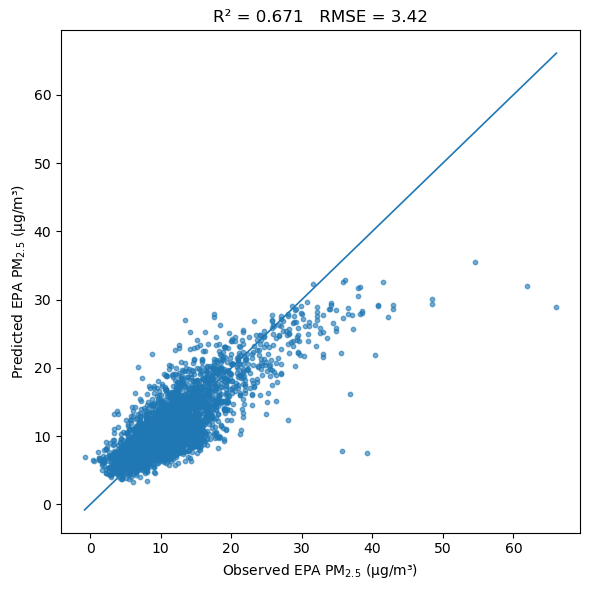

In [293]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import Ridge

csv_path = '../Data/Output/Paired_table_025.csv'
pair_df  = pd.read_csv(csv_path)

pm_lo, pm_hi = 1.5, 1000
df_clean = (pair_df
            .loc[pair_df["PurpleAir_PM25"].between(pm_lo, pm_hi)]
            .dropna(subset=["EPA_PM25", "PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]))

y_true = df_clean["EPA_PM25"].values
X = df_clean[["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]]

# EPA_PM₂.₅ (预测)
'''
EPA = β₀ + β₁·PA + β₂·RH + β₃·T
'''
pipe = Pipeline([
    ("scale", StandardScaler()),     # 保证不同量纲可比；如不想标准化可删
    ("lin",   LinearRegression())    # 换成 Ridge(alpha=1.0) 即为带惩罚的 β
])

cv      = KFold(n_splits = 5, shuffle = True, random_state = 42)
y_pred  = cross_val_predict(pipe, X, y_true, cv = cv)
r2      = r2_score(y_true, y_pred)
rmse    = mean_squared_error(y_true, y_pred, squared=False)

plt.figure(figsize = (6, 6))
plt.scatter(y_true, y_pred, alpha = 0.6, s = 10)
axis_min, axis_max = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([axis_min, axis_max], [axis_min, axis_max], lw=1.2)
plt.xlabel("Observed EPA PM$_{2.5}$ (µg/m³)")
plt.ylabel("Predicted EPA PM$_{2.5}$ (µg/m³)")
plt.title(f"R² = {r2:.3f}   RMSE = {rmse:.2f}")
plt.tight_layout()
plt.show()

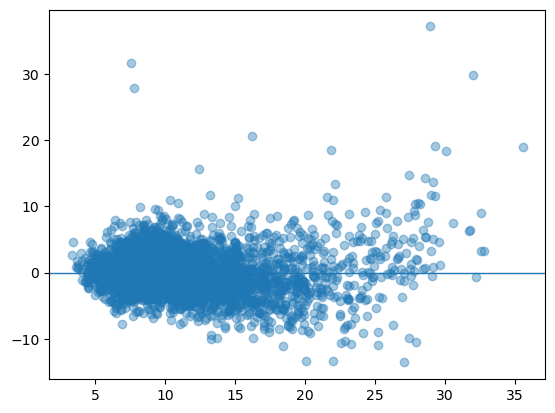

In [291]:
resid = y_true - y_pred
plt.scatter(y_pred, resid, alpha=0.4)
plt.axhline(0, lw=1)

In [295]:
X_ols = sm.add_constant(X)                # β₀ 截距
model  = sm.OLS(y, X_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     2422.
Date:                Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:49:42   Log-Likelihood:                -9399.3
No. Observations:                3550   AIC:                         1.881e+04
Df Residuals:                    3546   BIC:                         1.883e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.4670      0.233     14.

# Apply Calibration to all sensors - based on 0.25 mi

In [209]:
Purpleair_pm25_valid = "../Data/Output/Purpleair_pm25_valid.shp"
pa_gdf = gpd.read_file(Purpleair_pm25_valid)

In [223]:
pa_gdf.columns

Index(['Unnamed_ 0', 'sensor_id', 'date', 'time_stamp', 'rssi', 'uptime_x',
       'pa_latency', 'humidity_a', 'humidity_b', 'temperatur', 'temperat_1',
       'pressure_a', 'pressure_b', 'voc_a', 'voc_b', 'pm2.5_atm_',
       'pm2.5_at_1', 'pm10.0_atm', 'pm10.0_a_1', 'sensor_ind', 'date_creat',
       'location_t', 'model', 'uptime_y', 'position_r', 'latitude',
       'longitude', 'altitude', 'confidence', 'pm25_avg', 'geometry',
       'PurpleAir_PM25', 'PurpleAir_RH', 'PurpleAir_T'],
      dtype='object')

In [267]:
pa_gdf["date"] = pd.to_datetime(pa_gdf["date"]) 
cols_needed = ["pm25_avg", "humidity_a", "humidity_b", "temperatur", "temperat_1"]
pa_gdf = pa_gdf.dropna(subset=cols_needed)
pa_gdf["PurpleAir_PM25"] = pa_gdf["pm25_avg"]
pa_gdf["PurpleAir_RH"]   = pa_gdf[["humidity_a", "humidity_b"]].mean(axis=1)
pa_gdf["PurpleAir_T"]    = pa_gdf[["temperatur", "temperat_1"]].mean(axis=1)

In [301]:
from sklearn.base import clone
mask = (pa_gdf["PurpleAir_PM25"].between(1.5, 1000) &
        pa_gdf["PurpleAir_RH"].between(0, 100) &
        pa_gdf["PurpleAir_T"].between(-10, 50) & 
        (pa_gdf["confidence"] > .6)) 
df_trim = pa_gdf[mask].copy()
X_pa = df_trim[["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]]

X_pa_sm = sm.add_constant(X_pa, has_constant = 'add')           # 加 'const' 列

## distance = 0.25 miles model

In [334]:
X_pa_sm = X_pa_sm[model.params.index]

df_trim["PA_PM25_cali_025"] = model.predict(X_pa_sm)
df_trim["diff_025"] = df_trim["PA_PM25_cali_025"] - df_trim["PurpleAir_PM25"]

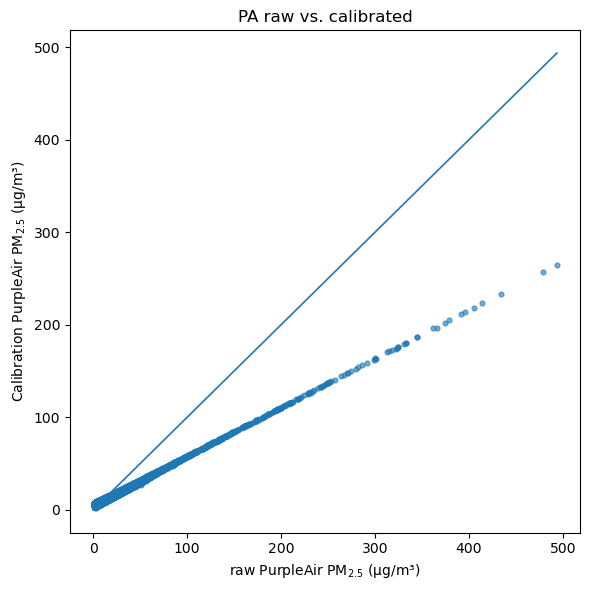

In [303]:
plt.figure(figsize = (6,6))
plt.scatter(df_trim["PurpleAir_PM25"],
            df_trim["PA_PM25_cali"], s = 12, alpha = 0.6)
plt.plot([0, df_trim[["PurpleAir_PM25","PA_PM25_cali"]].max().max()],
         [0, df_trim[["PurpleAir_PM25","PA_PM25_cali"]].max().max()], lw=1.2)
plt.xlabel("raw PurpleAir PM$_{2.5}$ (µg/m³)")
plt.ylabel("Calibration PurpleAir PM$_{2.5}$ (µg/m³)")
plt.title("PA raw vs. calibrated")
plt.tight_layout()
plt.show()

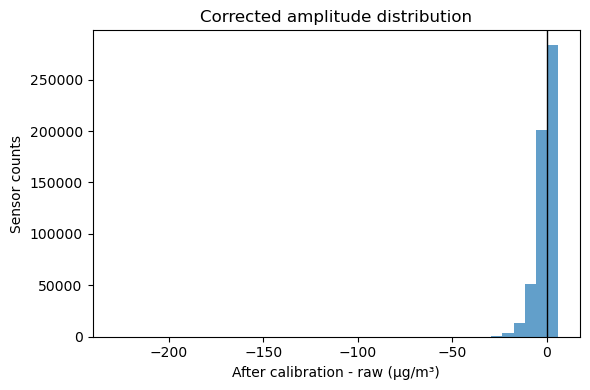

In [305]:
plt.figure(figsize = (6,4))
plt.hist(df_trim["diff"], bins = 40, alpha = 0.7)
plt.axvline(0, color = "k", lw = 1)
plt.xlabel("After calibration - raw (µg/m³)")
plt.ylabel("Sensor counts")
plt.title("Corrected amplitude distribution")
plt.tight_layout()
plt.show()

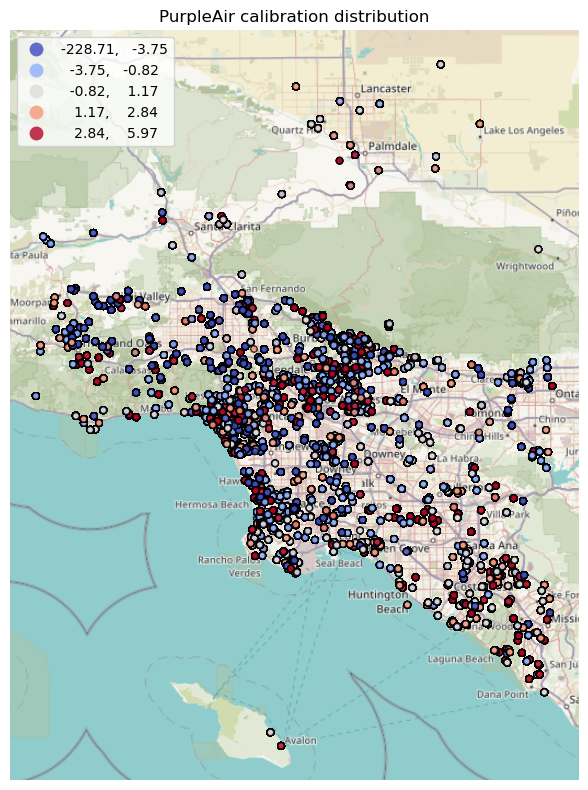

In [320]:
import contextily as cx
pa_web = df_trim.to_crs(epsg = 3857)

fig, ax = plt.subplots(figsize = (8,8))
pa_web.plot(column="diff",
            cmap="coolwarm", scheme="quantiles", k=5,
            marker="o", markersize=22, alpha=0.8, edgecolor="k",
            legend=True, ax=ax)

cx.add_basemap(ax, crs = pa_web.crs, attribution=False)
ax.set_axis_off()
plt.title("PurpleAir calibration distribution (new - old)")
plt.tight_layout()
plt.show() # red -> new value is higher

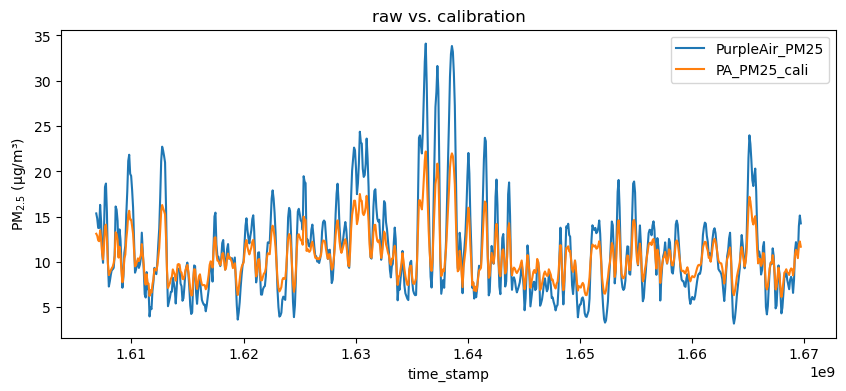

In [318]:
ts = (df_trim
      .groupby("time_stamp")[["PurpleAir_PM25","PA_PM25_cali"]]
      .mean()
      .rolling(window = 3, center = True).mean())      # 平滑一下

ts.plot(figsize=(10,4))
plt.ylabel("PM$_{2.5}$ (µg/m³)")
plt.title("raw vs. calibration")
plt.show()

## model - 0.5 miles

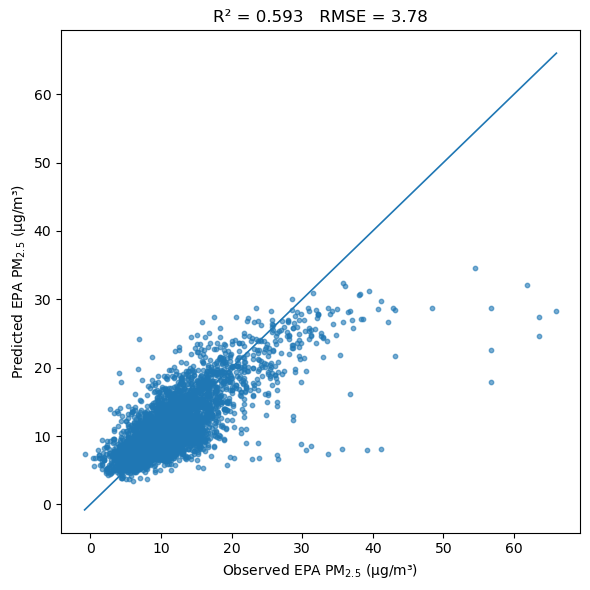

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2138.
Date:                Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:24:37   Log-Likelihood:                -12033.
No. Observations:                4379   AIC:                         2.407e+04
Df Residuals:                    4375   BIC:                         2.410e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.9320      0.195     20.

In [330]:
y_true = df_clean["EPA_PM25"].values
X = df_clean[["PurpleAir_PM25", "PurpleAir_RH", "PurpleAir_T"]]

# EPA_PM₂.₅ (预测)
'''
EPA = β₀ + β₁·PA + β₂·RH + β₃·T
'''
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("lin",   LinearRegression())
])

cv      = KFold(n_splits = 5, shuffle = True, random_state = 42)
y_pred  = cross_val_predict(pipe, X, y_true, cv = cv)
r2      = r2_score(y_true, y_pred)
rmse    = mean_squared_error(y_true, y_pred, squared=False)

plt.figure(figsize = (6, 6))
plt.scatter(y_true, y_pred, alpha = 0.6, s = 10)
axis_min, axis_max = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([axis_min, axis_max], [axis_min, axis_max], lw=1.2)
plt.xlabel("Observed EPA PM$_{2.5}$ (µg/m³)")
plt.ylabel("Predicted EPA PM$_{2.5}$ (µg/m³)")
plt.title(f"R² = {r2:.3f}   RMSE = {rmse:.2f}")
plt.tight_layout()
plt.show()

X_ols = sm.add_constant(X) 
model_05  = sm.OLS(y_true, X_ols).fit()
print(model_05.summary())

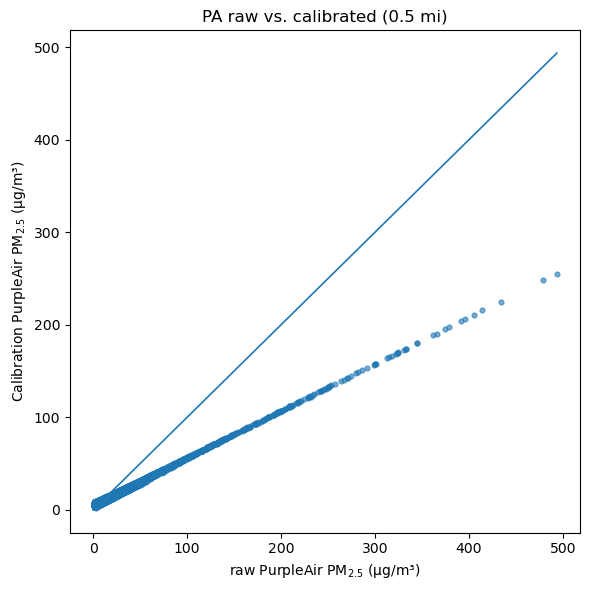

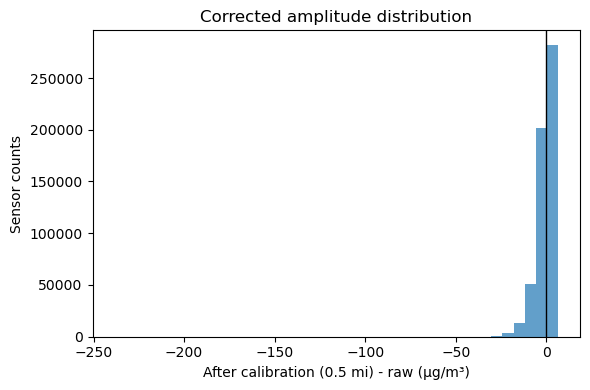

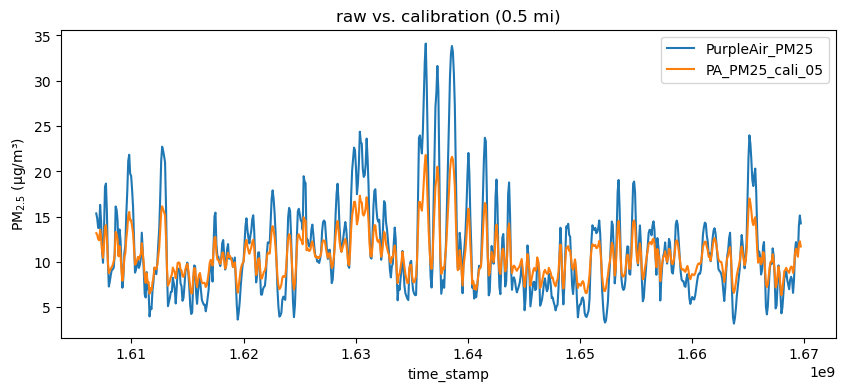

In [336]:
X_pa_sm = X_pa_sm[model_05.params.index]
df_trim["PA_PM25_cali_05"] = model_05.predict(X_pa_sm)
df_trim["diff_05"] = df_trim["PA_PM25_cali_05"] - df_trim["PurpleAir_PM25"]

plt.figure(figsize = (6,6))
plt.scatter(df_trim["PurpleAir_PM25"],
            df_trim["PA_PM25_cali_05"], s = 12, alpha = 0.6)
plt.plot([0, df_trim[["PurpleAir_PM25","PA_PM25_cali_05"]].max().max()],
         [0, df_trim[["PurpleAir_PM25","PA_PM25_cali_05"]].max().max()], lw=1.2)
plt.xlabel("raw PurpleAir PM$_{2.5}$ (µg/m³)")
plt.ylabel("Calibration PurpleAir PM$_{2.5}$ (µg/m³)")
plt.title("PA raw vs. calibrated (0.5 mi)")
plt.tight_layout()
plt.show()

plt.figure(figsize = (6,4))
plt.hist(df_trim["diff_05"], bins = 40, alpha = 0.7)
plt.axvline(0, color = "k", lw = 1)
plt.xlabel("After calibration (0.5 mi) - raw (µg/m³)")
plt.ylabel("Sensor counts")
plt.title("Corrected amplitude distribution")
plt.tight_layout()
plt.show()

ts = (df_trim
      .groupby("time_stamp")[["PurpleAir_PM25","PA_PM25_cali_05"]]
      .mean()
      .rolling(window = 3, center = True).mean())      # 平滑一下

ts.plot(figsize=(10,4))
plt.ylabel("PM$_{2.5}$ (µg/m³)")
plt.title("raw vs. calibration (0.5 mi)")
plt.show()

In [352]:
df_trim.columns

Index(['Unnamed_ 0', 'sensor_id', 'date', 'time_stamp', 'rssi', 'uptime_x',
       'pa_latency', 'humidity_a', 'humidity_b', 'temperatur', 'temperat_1',
       'pressure_a', 'pressure_b', 'voc_a', 'voc_b', 'pm2.5_atm_',
       'pm2.5_at_1', 'pm10.0_atm', 'pm10.0_a_1', 'sensor_ind', 'date_creat',
       'location_t', 'model', 'uptime_y', 'position_r', 'latitude',
       'longitude', 'altitude', 'confidence', 'pm25_avg', 'geometry',
       'PurpleAir_PM25', 'PurpleAir_RH', 'PurpleAir_T', 'PA_PM25_cali_025',
       'PA_PM25_cali_05', 'diff_05', 'diff_025'],
      dtype='object')

In [354]:
df_trim["date"] = df_trim["date"].astype('str')
df_trim.to_file("../Data/Output/PurpleAir_after_Calibration.shp")

C:\Users\jduan\AppData\Local\Temp\ipykernel_14252\2328677505.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df_trim.to_file("PurpleAir_after_Calibration.shp")


In [358]:
df_trim.columns

Index(['Unnamed_ 0', 'sensor_id', 'date', 'time_stamp', 'rssi', 'uptime_x',
       'pa_latency', 'humidity_a', 'humidity_b', 'temperatur', 'temperat_1',
       'pressure_a', 'pressure_b', 'voc_a', 'voc_b', 'pm2.5_atm_',
       'pm2.5_at_1', 'pm10.0_atm', 'pm10.0_a_1', 'sensor_ind', 'date_creat',
       'location_t', 'model', 'uptime_y', 'position_r', 'latitude',
       'longitude', 'altitude', 'confidence', 'pm25_avg', 'geometry',
       'PurpleAir_PM25', 'PurpleAir_RH', 'PurpleAir_T', 'PA_PM25_cali_025',
       'PA_PM25_cali_05', 'diff_05', 'diff_025'],
      dtype='object')